<a href="https://colab.research.google.com/github/ykitaguchi77/FundusPhoto/blob/main/Metabo2024-2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Metabo2024-2**

to do
```
・Finetune pretrained age estimation model
・※pretrained model: MAE=2.88、Metabo2024の最後で検証済み
```

##**Load pretrained weight**

In [ ]:
# 必要ライブラリ読み込み
!pip install timm==0.5.4 --q
import random
import timm
import copy
import torchvision.transforms as transforms
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from timm.scheduler import CosineLRScheduler
import numpy as np
from PIL import Image
from tqdm.notebook import tqdm
import os
import glob
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import mean_squared_error, r2_score
import time
import matplotlib.pyplot as plt
%matplotlib inline


# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# モデル枠組み読み込み
model = timm.create_model(model_name='swin_base_patch4_window12_384', num_classes=1, pretrained=False)

# GPU使用する場合
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 学習済みモデル読み込み
model_path = '/content/drive/MyDrive/Deep_learning/Fundus_metabolic/model_20220903.pth'
#model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.load_state_dict(torch.load(model_path))


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.5/431.5 kB 8.7 MB/s eta 0:00:00
Mounted at /content/drive


/usr/local/lib/python3.10/dist-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
<ipython-input-1-4e8bceffdcfa>:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_saf

<All keys matched successfully>

###**Load cleaned dataset**

・['AH', 'Blur']を削除したもの

In [ ]:
original_csv_path = "/content/drive/MyDrive/Deep_learning/Fundus_metabolic/label_train.csv"
original_df = pd.read_csv(original_csv_path)

# Load the provided metabo_disease.csv file again
disease_csv_path = '/content/drive/MyDrive/Deep_learning/Fundus_metabolic/metabo_disease.csv'
disease_df = pd.read_csv(disease_csv_path)

# Filter the disease_df to get only rows where reason is "AH" or "Blur"
#exclude_df = disease_df[disease_df['reason'].isin(['AH', 'Blur', 'ERM', "Hemorrhage", "Coagulation", "VO", "Degeneration", "AMD", "CRA", "Drusen"])]
exclude_df = disease_df[disease_df['reason'].isin(['AH', 'Blur', 'ERM', "Hemorrhage", "Coagulation", "VO", "Degeneration", "AMD", "CRA", "Drusen"])]

# Extract the ids (filenames) from ah_blur_df that match the 'AH' or 'Blur' criteria
ah_blur_ids = exclude_df['id'].tolist()

# Now remove these filenames from comparison_df
cleaned_df = original_df[~original_df['filename'].isin(ah_blur_ids)]
len(cleaned_df)

4618

##**Finetune age estimation model**

1e-7➡2e-6: MSE 13.2399, R2 0.8778

1e-6➡1e-4: MSE


optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

# CosineLRSchedulerの設定
scheduler = CosineLRScheduler(
    optimizer,
    t_initial=num_epochs,
    lr_min=1e-6,
    warmup_t=5,
    warmup_lr_init=1e-7,
    warmup_prefix=True
)

<ipython-input-4-c6a3ab544399>:86: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Epoch 1/200
Train Loss: 11.1510, Train MSE: 11.1525, Train R2: 0.9014
Val Loss: 13.4019, Val MSE: 13.4434, Val R2: 0.8759
Epoch duration: 227.46 seconds
Best model updated
Current learning rate: 0.000000
----------------------------------------
Epoch 2/200
Train Loss: 11.1252, Train MSE: 11.1242, Train R2: 0.9017
Val Loss: 13.3816, Val MSE: 13.4232, Val R2: 0.8761
Epoch duration: 226.43 seconds
Best model updated
Current learning rate: 0.000001
----------------------------------------
Epoch 3/200
Train Loss: 10.8991, Train MSE: 10.9010, Train R2: 0.9036
Val Loss: 13.3369, Val MSE: 13.3789, Val R2: 0.8765
Epoch duration: 227.21 seconds
Best model updated
Current learning rate: 0.000001
----------------------------------------
Epoch 4/200
Train Loss: 10.7215, Train MSE: 10.7248, Train R2: 0.9052
Val Loss: 13.2983, Val MSE: 13.3388, Val R2: 0.8769
Epoch duration: 226.49 seconds
Best model updated
Current learning rate: 0.000002
----------------------------------------
Epoch 5/200
Train Lo

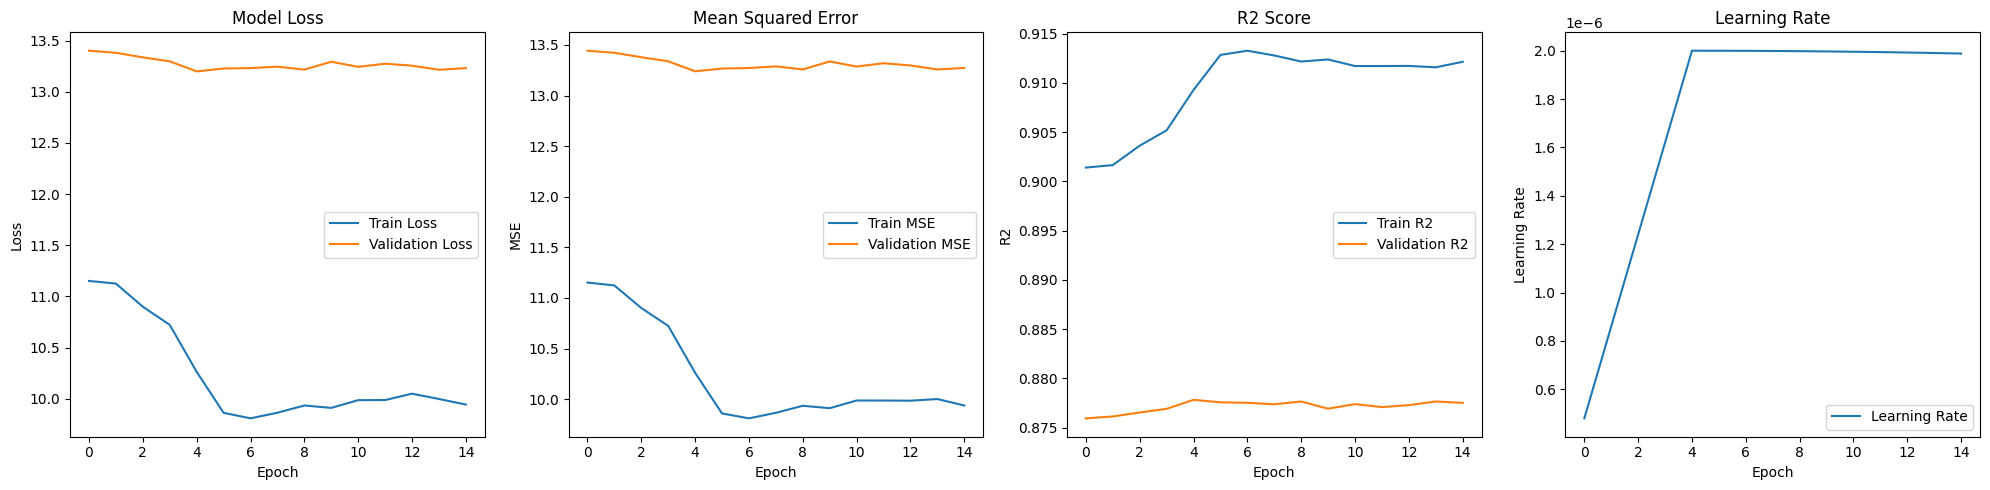

In [ ]:
# Training settings
num_epochs = 200
patience = 10
seed = 42
img_dir = "/content/drive/MyDrive/Deep_learning/Fundus_metabolic/images_whole_384px"



def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)


# データセットクラスの定義
class FundusDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.data = dataframe
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.data.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        label = self.data.iloc[idx, 1]  # AGEカラムのインデックス

        if self.transform:
            image = self.transform(image)

        return image, label

# データの前処理とオーグメンテーション
transform_train = transforms.Compose([
    #transforms.Resize((224, 224)),
    #transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=5),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1),
    transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0)),
    transforms.ToTensor(),
    #transforms.RandomGrayscale(p=0.1),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 検証用の変換（オーグメンテーションなし）
transform_val = transforms.Compose([
    #transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

full_dataset = FundusDataset(cleaned_df, img_dir)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

train_dataset.dataset.transform = transform_train
val_dataset.dataset.transform = transform_val

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2, pin_memory=True)

model = model.to(device)

criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

# CosineLRSchedulerの設定
scheduler = CosineLRScheduler(
    optimizer,
    t_initial=num_epochs,
    lr_min=1e-6,
    warmup_t=5,
    warmup_lr_init=1e-7,
    warmup_prefix=True
)

scaler = torch.cuda.amp.GradScaler()


# Early Stopping クラス
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_model = None

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model.state_dict())
            return True
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model.state_dict())
            self.counter = 0
            return True
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
            return False

# トレーニング関数の修正
def train(model, train_loader, criterion, optimizer, device, scaler):
    model.train()
    running_loss = 0.0
    all_targets = []
    all_predictions = []

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device).float()
        inputs = inputs.to(memory_format=torch.channels_last)

        for param in model.parameters():
            param.grad = None

        with torch.amp.autocast(device_type='cuda'):
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, targets)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        all_targets.extend(targets.cpu().numpy())
        all_predictions.extend(outputs.detach().cpu().numpy())

    epoch_loss = running_loss / len(train_loader)
    mse = mean_squared_error(all_targets, all_predictions)
    r2 = r2_score(all_targets, all_predictions)
    return epoch_loss, mse, r2

# 評価関数の修正
def evaluate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device).float()
            inputs = inputs.to(memory_format=torch.channels_last)
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, targets)

            running_loss += loss.item()
            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(outputs.cpu().numpy())

    epoch_loss = running_loss / len(val_loader)
    mse = mean_squared_error(all_targets, all_predictions)
    r2 = r2_score(all_targets, all_predictions)
    return epoch_loss, mse, r2

# GradScalerの更新
scaler = torch.amp.GradScaler('cuda')

# モデルの出力層の調整（必要に応じて）
# model.fc = nn.Linear(model.fc.in_features, 1)  # 1つの出力（回帰の場合）

# 損失関数の変更
criterion = nn.MSELoss()  # 回帰問題の場合

# トレーニングループの修正
early_stopping = EarlyStopping(patience=patience)
history = {'train_loss': [], 'train_mse': [], 'train_r2': [],
           'val_loss': [], 'val_mse': [], 'val_r2': [], 'lr': []}

for epoch in range(num_epochs):
    epoch_start_time = time.time()

    train_loss, train_mse, train_r2 = train(model, train_loader, criterion, optimizer, device, scaler)
    val_loss, val_mse, val_r2 = evaluate(model, val_loader, criterion, device)

    scheduler.step(epoch + 1)

    current_lr = optimizer.param_groups[0]['lr']
    history['lr'].append(current_lr)

    epoch_end_time = time.time()
    epoch_duration = epoch_end_time - epoch_start_time

    history['train_loss'].append(train_loss)
    history['train_mse'].append(train_mse)
    history['train_r2'].append(train_r2)
    history['val_loss'].append(val_loss)
    history['val_mse'].append(val_mse)
    history['val_r2'].append(val_r2)

    is_best = early_stopping(val_loss, model)

    if early_stopping.best_model is not None:
        model.load_state_dict(early_stopping.best_model)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train MSE: {train_mse:.4f}, Train R2: {train_r2:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val MSE: {val_mse:.4f}, Val R2: {val_r2:.4f}")
    print(f"Epoch duration: {epoch_duration:.2f} seconds")
    print(f"Best model {'updated' if is_best else 'not updated'}")
    print(f"Current learning rate: {current_lr:.6f}")
    print("-" * 40)

    if early_stopping.early_stop:
        print("Early stopping triggered")
        break

# 最終評価の修正
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.to(memory_format=torch.channels_last)
        outputs = model(inputs).squeeze()
        all_preds.extend(outputs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

final_mse = mean_squared_error(all_labels, all_preds)
final_r2 = r2_score(all_labels, all_preds)
print(f"Final MSE: {final_mse:.4f}")
print(f"Final R2 Score: {final_r2:.4f}")

# 訓練結果のグラフ表示
plt.figure(figsize=(20, 5))

plt.subplot(1, 4, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 4, 2)
plt.plot(history['train_mse'], label='Train MSE')
plt.plot(history['val_mse'], label='Validation MSE')
plt.title('Mean Squared Error')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

plt.subplot(1, 4, 3)
plt.plot(history['train_r2'], label='Train R2')
plt.plot(history['val_r2'], label='Validation R2')
plt.title('R2 Score')
plt.xlabel('Epoch')
plt.ylabel('R2')
plt.legend()

plt.subplot(1, 4, 4)
plt.plot(history['lr'], label='Learning Rate')
plt.title('Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error

# 散布図の追加（サイズを大きくする）
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.scatter(all_labels, all_preds, alpha=0.5)
plt.plot([min(all_labels), max(all_labels)], [min(all_labels), max(all_labels)], 'r--', lw=2)
plt.xlabel('True Values', fontsize=12)
plt.ylabel('Predictions', fontsize=12)
plt.title('True vs Predicted Values', fontsize=14)

# 残差プロットの追加
residuals = np.array(all_labels) - np.array(all_preds)
plt.subplot(2, 2, 2)
plt.scatter(all_preds, residuals, alpha=0.5)
plt.xlabel('Predicted Values', fontsize=12)
plt.ylabel('Residuals', fontsize=12)
plt.title('Residual Plot', fontsize=14)
plt.axhline(y=0, color='r', linestyle='--')

plt.tight_layout()
plt.show()

# MAEの計算
mae = mean_absolute_error(all_labels, all_preds)
print(f"Mean Absolute Error (MAE): {mae:.4f}")

In [ ]:
import torch
import os

# モデルの保存先パスを設定
save_path = "/content/drive/MyDrive/Deep_learning/Fundus_metabolic/models/finetune_agemodel/age.pth"

# パスが存在することを確認し、必要に応じてディレクトリを作成
os.makedirs(os.path.dirname(save_path), exist_ok=True)

# モデルの状態辞書を保存
torch.save(model.state_dict(), save_path)

print(f"Model saved successfully to {save_path}")

# オプション: モデルの読み込みを確認
# モデルの状態辞書を読み込む
loaded_state_dict = torch.load(save_path)

# 新しいモデルインスタンスに状態辞書を適用する
# (ここでは 'model' が既に定義されていると仮定しています)
model.load_state_dict(loaded_state_dict)

print("Model loaded successfully for verification.")

### 学習がうまくいかないことに対する対応版

##**Finetune other classification model**

```
分ける基準
Age: <45: 1901, >=58: 929 --> age estimation modelが完成済
AC: <85: 1555, >=95: 1410
SBP: <125: 1429, >=140: 1374
DBP: <80: 2055, >=85: 2111
HDLC: <45: 1349, >60: 1496
TG: <100: 1608, >=200: 1414
#BS: <75: 204, >=130: 398 --> 眼底で分別
```

In [ ]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Load the dataset from your specified path
file_path = '/content/drive/MyDrive/Deep_learning/Fundus_metabolic/label_train.csv'
data = pd.read_csv(file_path)

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Deep_learning/Fundus_metabolic/label_train.csv'

In [ ]:
# Create new columns to classify the data based on the provided thresholds
data['AC_class'] = data['AC'].apply(lambda x: 'low' if x < 85 else 'high' if x >= 95 else 'mid')
data['SBP_class'] = data['SBP'].apply(lambda x: 'low' if x < 125 else 'high' if x >= 140 else 'mid')
data['DBP_class'] = data['DBP'].apply(lambda x: 'low' if x < 80 else 'high' if x >= 85 else 'mid')
data['HDLC_class'] = data['HDLC'].apply(lambda x: 'low' if x < 45 else 'high' if x > 60 else 'mid')
data['TG_class'] = data['TG'].apply(lambda x: 'low' if x < 100 else 'high' if x >= 200 else 'mid')

# Display the updated dataframe with the new classification columns
import ace_tools as tools; tools.display_dataframe_to_user(name="Classified Data", dataframe=data)

data[['filename', 'AC_class', 'SBP_class', 'DBP_class', 'HDLC_class', 'TG_class']].head()
